In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm

import math

from collections import OrderedDict


import scanpy as sc
import os


In [2]:
## Load adipose data
UCE_filtered_DIR = '/home/syyang/GitRepo/cs294/finalproject/data/UCEgenes_anndata'

adipose_sn_file = 'adata_with_infer_multiresleiden_toR_Xastypeinteger_proc.h5ad'
adipose_sn_ad = sc.read_h5ad(os.path.join(UCE_filtered_DIR,  adipose_sn_file) )

adipose_sn_ad.obs['sample'] = adipose_sn_ad.obs['sample'].astype('category')
adipose_sn_ad.obs['leiden_scVI_res0.9'] = adipose_sn_ad.obs['leiden_scVI_res0.9'].astype('category')

In [3]:
class scDataset(Dataset):
    def __init__(self, adata):
        """
        adata: AnnData object
        cat: from adata.obs['sample']
        labels: from adata.obs['leiden_scVI_res0.9'] --> Need to be changed to cell type
        """
        self.obs = adata.obs
        self.data = torch.log(torch.tensor(adata.layers['counts'].toarray() + 1. ))  # log transform
        #self.data =  torch.tensor(adata.layers['counts'].toarray())
        self.local_library_mean = self.data.sum(axis=1)
        self.local_library_var = torch.tensor([1.])
        
        self.cat = torch.tensor(adata.obs['sample'].cat.codes.values).to(torch.int64) # sample labels
        self.n_cat = adata.obs['sample'].nunique()
        self.labels = torch.tensor(adata.obs['leiden_scVI_res0.9'].cat.codes.values).to(torch.int64)   # cell type labels
        self.n_labels = adata.obs['leiden_scVI_res0.9'].nunique()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # onehot encode `cat` and `labels`
        cat_onehot = F.one_hot(self.cat[idx], self.n_cat)
        label_onehot = F.one_hot(self.labels[idx], self.n_labels)
        
        return self.data[idx], cat_onehot, label_onehot, self.local_library_mean[idx], self.local_library_var 
    

# Example
# adipose_dataset = scDataset(adipose_sn_ad)
# data_loader = DataLoader(adipose_dataset, batch_size=10, shuffle=False)
# a = next(iter(data_loader))
    

In [4]:
class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(LinearBlock, self).__init__()
        layers = [
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim, momentum=.01, eps=0.001),
            nn.ReLU(),
        ]
        if dropout:
            layers.append(nn.Dropout(p=dropout))
            
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

class Encoder_x(nn.Module):
    """_summary_
        This encodes the latent space of the data vector x
    Args:
        nn (_type_): _description_
        latent_dim: 1280, same as the latent_dim in the UCE model (UCE: \ref[Rosen, Yanay, et al. "Universal Cell Embeddings: A Foundation Model for Cell Biology." bioRxiv (2023): 2023-11.])
        
    """
    def __init__(self, input_dim, latent_dim=1280, hidden_dim=1280, hidden_layers=1):
        super(Encoder_x, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, cell_type_one_hot=None):
        if cell_type_one_hot is not None:
            x = torch.cat([x, cell_type_one_hot], dim=1) # cell_type_one_hot is the one_hot encoded cell_type_index  
        x = self.layers(x)
        qz_mean = self.linear_mean(x)
        qz_var = torch.exp(self.linear_var(x))
        #z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        return qz_mean, qz_var #, z_dist
    
    
class Encoder_l(nn.Module):
    """_summary_
        This encodes the library size, which is affected by observation x 
        
    Args:
        nn (_type_): _description_
        latent_dim: 1
        
    """
    def __init__(self, input_dim, latent_dim=1, hidden_dim=20, hidden_layers=1):
        super(Encoder_l, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -2) + [[hidden_dim, latent_dim]]
        self.layers = nn.Sequential(
            *[LinearBlock(dim[0], dim[1]) for dim in layer_dims]
        )
        self.linear_mean = nn.Linear(latent_dim, latent_dim)
        self.linear_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x):
        x = self.layers(x)
        ql_mean = self.linear_mean(x)
        ql_var = torch.exp(self.linear_var(x))
        #library_dist = torch.distributions.Normal(ql_mean, ql_var.sqrt())
        return ql_mean, ql_var #, library_dist
    

    
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=1280, hidden_layers=1):
        super(Decoder, self).__init__()
        
        layer_dims = [[input_dim, hidden_dim]] + [[hidden_dim, hidden_dim]] * (hidden_layers -1) 
        self.decoder = nn.Sequential(
            *[LinearBlock(dim[0], dim[1], dropout=None) for dim in layer_dims]
        )
        
        self.px_dropout_decoder = nn.Linear(hidden_dim, output_dim)  # the logit of the dropout rate
        self.px_scale_decoder = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Softmax(dim=-1))
        self.px_dispersion_decoder = nn.Linear(hidden_dim, output_dim)
        

    def forward(self, z, library, cat_one_hot):
        
        input = torch.cat([z, cat_one_hot], dim=1) # cat_index is the one_hot encoded cell_type_index
        x = self.decoder(input)
        
        px_scale = self.px_scale_decoder(x)
        #px_rate = torch.exp(library) * px_scale  # encode library size
        px_rate = library * px_scale  # use observed library size

        
        px_dispersion = self.px_dispersion_decoder(x)
        px_dropout = self.px_dropout_decoder(x)
        
        px_dispersion = torch.exp(px_dispersion)  # positive value
        
        return px_rate, px_dispersion, px_dropout 
    
    

    
def log_zinb_positive(
    x: torch.Tensor,
    mu: torch.Tensor,
    theta: torch.Tensor,
    pi: torch.Tensor,
    eps: float = 1e-8,
) -> torch.Tensor:
    """
    Adapted From `https://github.com/scverse/scvi-tools`  with minor modifications
     
    Log likelihood (scalar) of a minibatch according to a zinb model.

    Parameters
    ----------
    x
        Data
    mu
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars)
    theta
        inverse dispersion parameter (has to be positive support) (shape: minibatch x vars)
    pi
        logit of the dropout parameter (real support) (shape: minibatch x vars)
    eps
        numerical stability constant

    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """
    # theta is the dispersion rate. If .ndimension() == 1, it is shared for all cells (regardless
    # of batch or labels)
    if theta.ndimension() == 1:
        theta = theta.view(1, theta.size(0))  # In this case, we reshape theta for broadcasting

    # Uses log(sigmoid(x)) = -softplus(-x)
    softplus_pi = F.softplus(-pi)
    log_theta_eps = torch.log(theta + eps)
    log_theta_mu_eps = torch.log(theta + mu + eps)
    pi_theta_log = -pi + theta * (log_theta_eps - log_theta_mu_eps)

    case_zero = F.softplus(pi_theta_log) - softplus_pi
    mul_case_zero = torch.mul((x < eps).type(torch.float32), case_zero)

    case_non_zero = (
        -softplus_pi
        + pi_theta_log
        + x * (torch.log(mu + eps) - log_theta_mu_eps)
        + torch.lgamma(x + theta)
        - torch.lgamma(theta)
        - torch.lgamma(x + 1)
    )
    mul_case_non_zero = torch.mul((x > eps).type(torch.float32), case_non_zero)
    

    # print(f"x[0, 0] is: {x[0,0]}")
    # print(f"torch.lgamma(x + theta)[0, 0] is: {torch.lgamma(x + theta)[0,0]}")
    # print(f"torch.lgamma(theta)[0, 0] is: {torch.lgamma(theta)[0,0]}")

    res = mul_case_zero + mul_case_non_zero

    return res



In [8]:
class snRNAseqVAE(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim, encode_hidden_dim, decode_hidden_dim, total_cat, total_cell_type, cell_type_encode=True):
        super(snRNAseqVAE, self).__init__()

        self.cell_type_encode = cell_type_encode 
        
        self.total_cat = total_cat
        self.total_cell_type = total_cell_type # total_cell_type = total-known-cell-types + 1 (for unknown cell type: 0) 
                
        if cell_type_encode:
            encoder_x_input_dim = input_dim + total_cell_type
        else:
            encoder_x_input_dim = input_dim
        self.encoder_x = Encoder_x(encoder_x_input_dim, latent_dim, hidden_dim=encode_hidden_dim,  hidden_layers=1)
        
        #self.encoder_l = Encoder_l(input_dim, 1)
        
        decoder_input_dim = latent_dim + total_cat  # total_cat is the total number of categories in the cat_index, indicates datasets 
        self.decoder = Decoder(decoder_input_dim, output_dim, hidden_dim=decode_hidden_dim, hidden_layers=1)
        
    def _inference(self, x, cat_one_hot, cell_type_one_hot, l):
        if self.cell_type_encode:
            qz_mean, qz_var = self.encoder_x(x, cell_type_one_hot)
        else:
            qz_mean, qz_var = self.encoder_x(x)
        #ql_mean, ql_var = self.encoder_l(x)
        z = torch.distributions.Normal(qz_mean, qz_var.sqrt()).rsample()
        #l = torch.distributions.Normal(ql_mean, ql_var.sqrt()).rsample()
        px_rate, px_dispersion, px_dropout  = self.decoder(z, l, cat_one_hot)
        #return qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout  # encode library size 
        return qz_mean, qz_var, px_rate, px_dispersion, px_dropout 
    
    
    def forward(self, x, local_l_mean, local_l_var, cat_one_hot, cell_type_one_hot):
        """_summary_

        Args:
            x (_type_): _description_
            local_l_mean (_type_): shape of [batch_size, 1]
            local_l_var (_type_): shape of [batch_size, 1]
            cat_one_hot (_type_): shape of [batch_size, n_cat]
            cell_type_one_hot (_type_): shape of [batch_size, n_cell_types]

        Returns:
            _type_: _description_
        """
        #local_l_mean =  x.sum(axis=1) outside of this function
        #local_l_var = 0 # should this be within batch? YES as it is observed and varies from batch to batch. FInish outside of this function

        
        #qz_mean, qz_var, ql_mean, ql_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)  # encode library size output 
        qz_mean, qz_var, px_rate, px_dispersion, px_dropout = self._inference(x, cat_one_hot, cell_type_one_hot, local_l_mean)
        z_dist = torch.distributions.Normal(qz_mean, qz_var.sqrt())
        #l_dist = torch.distributions.Normal(ql_mean, ql_var)

        kl_z = torch.distributions.kl.kl_divergence(z_dist, torch.distributions.Normal(torch.zeros_like(qz_mean), torch.ones_like(qz_var))).sum(axis=1)
        #kl_l = torch.distributions.kl.kl_divergence(l_dist, torch.distributions.Normal(local_l_mean, local_l_var.sqrt())).sum(axis=1)
        
        reconst_loss = -log_zinb_positive(x, px_rate, px_dispersion, px_dropout).sum(axis=-1)

        return (reconst_loss + kl_z ).mean() #, reconst_loss.mean(), kl_z.mean(), kl_l.mean()
        #return (reconst_loss + kl_z ).mean()

In [9]:
## Training 
def trainning(model, train_loader, device, optimizer, n_epochs=100):
    model = model.to(device)
    model.train()
    train_loss = []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_loss = 0
        N = 0
        for i, data in enumerate(train_loader):
            x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
            
            x = x.to(device)
            cat_onehot = cat_onehot.to(device)
            label_onehot = label_onehot.to(device)
            local_library_mean = local_library_mean.to(device).view((-1,1))  # size of [batch_size, 1]
            local_library_var = local_library_var.to(device).view((-1,1))  # size of [batch_size, 1]
            
            optimizer.zero_grad()
            loss = model(x, local_library_mean, local_library_var, cat_onehot, label_onehot) 
            loss.backward()
            total_loss += loss.item() * x.size(0)
            N += x.size(0)
            optimizer.step()
        print("Epoch: ", epoch, "Loss: ", total_loss/N )
        train_loss.append(total_loss/N)
        
    return train_loss

In [11]:
## Data
train_data = adipose_sn_ad#[adipose_sn_ad.obs['sample'] == '03_SQ', ]
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=True)

## set model 
total_cat = adipose_dataset.obs['sample'].nunique()
total_cell_type = adipose_dataset.obs['leiden_scVI_res0.9'].nunique()
output_dim  = adipose_dataset.data.shape[1]
model = snRNAseqVAE(input_dim=adipose_dataset.data.shape[1], output_dim=output_dim, \
    latent_dim=1280, encode_hidden_dim=1280, decode_hidden_dim=1280, total_cat=total_cat, total_cell_type=total_cell_type, cell_type_encode=False)

optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=0.01)

train_loss = trainning(model, data_loader, device='cuda', optimizer=optimizer, n_epochs=50)

  2%|▏         | 1/50 [00:05<04:15,  5.22s/it]

Epoch:  0 Loss:  3257.0232125614466


  4%|▍         | 2/50 [00:10<04:09,  5.19s/it]

Epoch:  1 Loss:  3046.3620872926176


  6%|▌         | 3/50 [00:15<04:03,  5.18s/it]

Epoch:  2 Loss:  3014.980884337693


  8%|▊         | 4/50 [00:20<04:00,  5.22s/it]

Epoch:  3 Loss:  2998.9601467861216


 10%|█         | 5/50 [00:25<03:53,  5.20s/it]

Epoch:  4 Loss:  2987.595696267117


 12%|█▏        | 6/50 [00:31<03:47,  5.17s/it]

Epoch:  5 Loss:  2979.405628675825


 14%|█▍        | 7/50 [00:36<03:43,  5.20s/it]

Epoch:  6 Loss:  2972.4625573318995


 16%|█▌        | 8/50 [00:41<03:37,  5.17s/it]

Epoch:  7 Loss:  2967.1741010687324


 18%|█▊        | 9/50 [00:46<03:32,  5.18s/it]

Epoch:  8 Loss:  2962.3680666805653


 20%|██        | 10/50 [00:51<03:26,  5.16s/it]

Epoch:  9 Loss:  2957.907133295295


 22%|██▏       | 11/50 [00:56<03:20,  5.14s/it]

Epoch:  10 Loss:  2954.08118567306


 24%|██▍       | 12/50 [01:02<03:16,  5.16s/it]

Epoch:  11 Loss:  2950.7329417025107


 26%|██▌       | 13/50 [01:07<03:09,  5.12s/it]

Epoch:  12 Loss:  2947.590828541959


 28%|██▊       | 14/50 [01:12<03:02,  5.06s/it]

Epoch:  13 Loss:  2943.7175505563114


 30%|███       | 15/50 [01:17<02:56,  5.05s/it]

Epoch:  14 Loss:  2940.7683071179335


 32%|███▏      | 16/50 [01:21<02:50,  5.00s/it]

Epoch:  15 Loss:  2937.3202987842346


 34%|███▍      | 17/50 [01:26<02:45,  5.00s/it]

Epoch:  16 Loss:  2933.8916255650897


 36%|███▌      | 18/50 [01:31<02:39,  4.97s/it]

Epoch:  17 Loss:  2930.422293330846


 38%|███▊      | 19/50 [01:36<02:32,  4.93s/it]

Epoch:  18 Loss:  2926.3265456296085


 40%|████      | 20/50 [01:41<02:27,  4.90s/it]

Epoch:  19 Loss:  2922.727914188685


 42%|████▏     | 21/50 [01:46<02:20,  4.86s/it]

Epoch:  20 Loss:  2918.7253616847347


 44%|████▍     | 22/50 [01:51<02:16,  4.86s/it]

Epoch:  21 Loss:  2915.277180532391


 46%|████▌     | 23/50 [01:55<02:10,  4.84s/it]

Epoch:  22 Loss:  2911.9255652266943


 48%|████▊     | 24/50 [02:00<02:06,  4.86s/it]

Epoch:  23 Loss:  2909.0352577466642


 50%|█████     | 25/50 [02:05<02:02,  4.91s/it]

Epoch:  24 Loss:  2906.3669954792836


 52%|█████▏    | 26/50 [02:10<01:57,  4.91s/it]

Epoch:  25 Loss:  2904.169944506013


 54%|█████▍    | 27/50 [02:15<01:53,  4.92s/it]

Epoch:  26 Loss:  2902.189817964361


 56%|█████▌    | 28/50 [02:20<01:48,  4.91s/it]

Epoch:  27 Loss:  2900.2019811051614


 58%|█████▊    | 29/50 [02:25<01:42,  4.90s/it]

Epoch:  28 Loss:  2898.660921589712


 60%|██████    | 30/50 [02:30<01:38,  4.92s/it]

Epoch:  29 Loss:  2897.1316665477966


 62%|██████▏   | 31/50 [02:35<01:33,  4.91s/it]

Epoch:  30 Loss:  2895.6260965754477


 64%|██████▍   | 32/50 [02:40<01:28,  4.94s/it]

Epoch:  31 Loss:  2894.43122778046


 66%|██████▌   | 33/50 [02:45<01:23,  4.92s/it]

Epoch:  32 Loss:  2892.805946607268


 68%|██████▊   | 34/50 [02:50<01:18,  4.91s/it]

Epoch:  33 Loss:  2891.615282380179


 70%|███████   | 35/50 [02:55<01:13,  4.93s/it]

Epoch:  34 Loss:  2890.115753516722


 72%|███████▏  | 36/50 [02:59<01:08,  4.92s/it]

Epoch:  35 Loss:  2888.8243833391853


 74%|███████▍  | 37/50 [03:04<01:04,  4.93s/it]

Epoch:  36 Loss:  2887.5540394300824


 76%|███████▌  | 38/50 [03:09<00:59,  4.92s/it]

Epoch:  37 Loss:  2886.601871790511


 78%|███████▊  | 39/50 [03:14<00:54,  4.91s/it]

Epoch:  38 Loss:  2885.4526737513165


 80%|████████  | 40/50 [03:19<00:49,  4.94s/it]

Epoch:  39 Loss:  2884.4328723007375


 82%|████████▏ | 41/50 [03:24<00:44,  4.92s/it]

Epoch:  40 Loss:  2883.667314507988


 84%|████████▍ | 42/50 [03:29<00:39,  4.95s/it]

Epoch:  41 Loss:  2882.5088260950665


 86%|████████▌ | 43/50 [03:34<00:34,  4.94s/it]

Epoch:  42 Loss:  2881.9804893236483


 88%|████████▊ | 44/50 [03:39<00:29,  4.92s/it]

Epoch:  43 Loss:  2881.13970398635


 90%|█████████ | 45/50 [03:44<00:24,  4.95s/it]

Epoch:  44 Loss:  2880.219177931882


 92%|█████████▏| 46/50 [03:49<00:19,  4.93s/it]

Epoch:  45 Loss:  2879.46189828937


 94%|█████████▍| 47/50 [03:54<00:14,  4.96s/it]

Epoch:  46 Loss:  2878.98183826918


 96%|█████████▌| 48/50 [03:59<00:09,  4.93s/it]

Epoch:  47 Loss:  2878.0661422215153


 98%|█████████▊| 49/50 [04:04<00:04,  4.92s/it]

Epoch:  48 Loss:  2874.813469704617


100%|██████████| 50/50 [04:09<00:00,  4.98s/it]

Epoch:  49 Loss:  2843.926954633734


In [12]:
# Get latent representation of the data
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        #qz_mean, _ = model.encoder_x(x, label_onehot)
        qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [13]:
train_data_2 = train_data.copy()
train_data_2.obsm['syy_VAE'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE')
sc.tl.umap(train_data_2)

In [14]:
train_data_2.obsm['syy_VAE'].shape

(71200, 1280)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


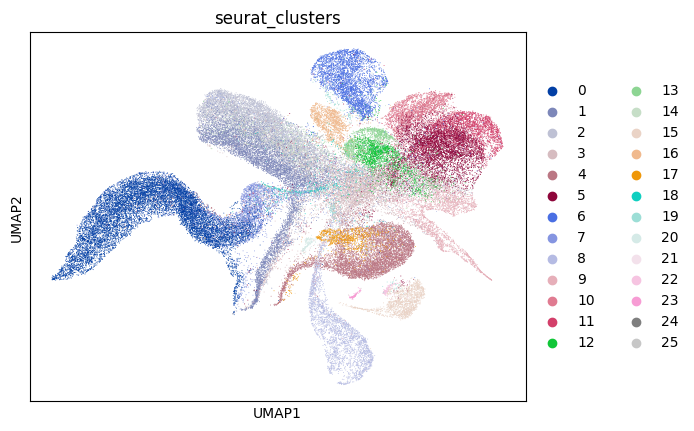

In [15]:
sc.pl.umap(train_data_2, color=['seurat_clusters'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


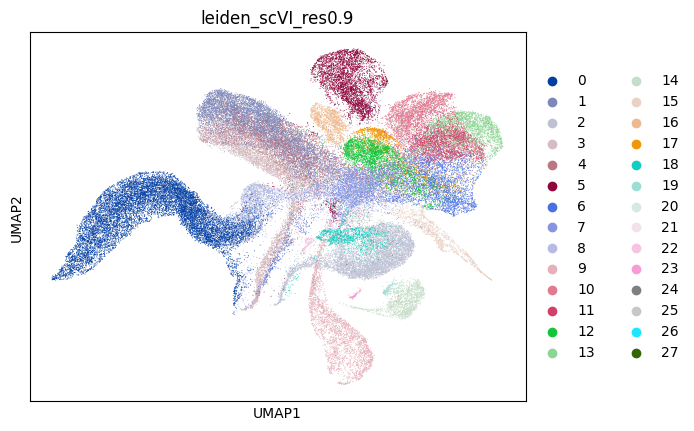

In [17]:
sc.pl.umap(train_data_2, color=['leiden_scVI_res0.9'] )

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


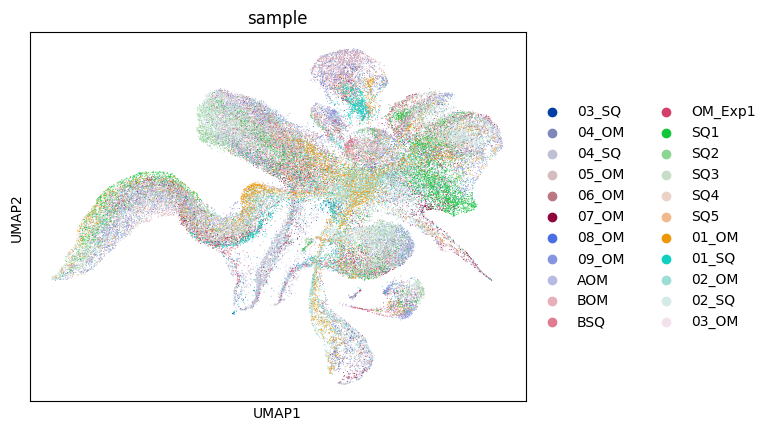

In [18]:
sc.pl.umap(train_data_2, color=['sample'] )

In [32]:
adipose_dataset = scDataset(train_data)
data_loader = DataLoader(adipose_dataset, batch_size=1000, shuffle=False)
z = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(data_loader):
        x, cat_onehot, label_onehot, local_library_mean, local_library_var = data
        x = x.to('cuda')
        cat_onehot = cat_onehot.to('cuda')
        label_onehot = label_onehot.to('cuda')
        local_library_mean = local_library_mean.to('cuda').view((-1,1))
        local_library_var = local_library_var.to('cuda').view((-1,1))
        #qz_mean, _ = model.encoder_x(x, label_onehot)
        qz_mean, _ = model.encoder_x(x)
        z.append(qz_mean.cpu().detach())

In [33]:
train_data_2.obsm['syy_VAE300epo'] = torch.cat(z).numpy()
sc.pp.neighbors(train_data_2, use_rep='syy_VAE300epo')
sc.tl.umap(train_data_2)

## SCVI's results as reference

In [97]:
sc.pp.neighbors(train_data, use_rep='X_scVI')
sc.tl.umap(train_data)

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


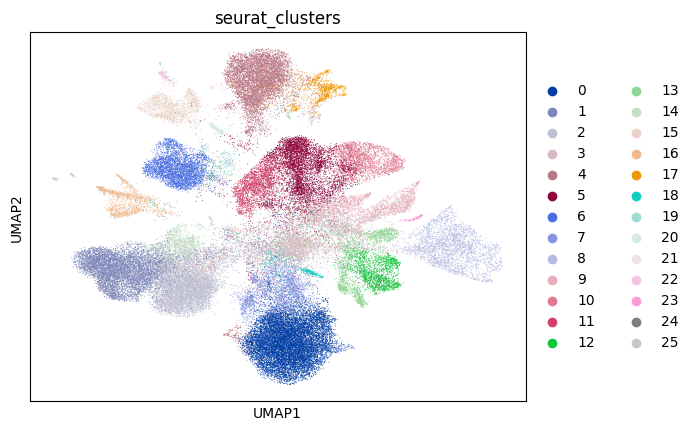

In [98]:
sc.pl.umap(train_data, color=['seurat_clusters'] )

In [60]:
#adipose_sn_ad_sp2.write_h5ad("/home/syyang/GitRepo/cs294/finalproject/script/adipose_with_VAE20270427.h5ad")

/home/syyang/python_virtuenv/omic3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


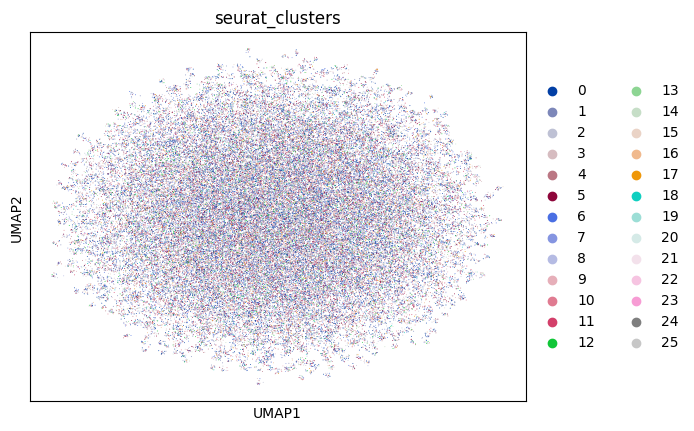

In [34]:
sc.pl.umap(adipose_sn_ad_sp2, color=['seurat_clusters'] )